In [1]:
import pandas as pd
import numpy as np

from pymongo import MongoClient
import os
import dotenv

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline as py

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import warnings

/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Mongo connection, extract and normalize

In [2]:
dotenv.load_dotenv()
MGURL = os.getenv("MGURL")
myclient = MongoClient(f"{MGURL}")
db = myclient.github

In [3]:
git = list(db.profiles.find({},{"_id":0, "company":0, "location":0, "email":0, "hireable":0}))

In [4]:
df = pd.json_normalize(git, "repos", ["name","repos_number","followers","created","updated"])

### Clean and prepare dataframe

In [5]:
print(df.shape)
df.head()

(1037132, 10)


,repo_name,forked,stars,language,forks,name,repos_number,followers,created,updated
0,AwesomeNER,False,6,Jupyter Notebook,2,Tarun Sudhams,23,33,2016-05-27T06:16:14Z,2020-05-05T07:34:00Z
1,coding-interview-university,True,2,None,1,Tarun Sudhams,23,33,2016-05-27T06:16:14Z,2020-05-05T07:34:00Z
2,COMP2396-assignments,False,0,Java,0,Tarun Sudhams,23,33,2016-05-27T06:16:14Z,2020-05-05T07:34:00Z
3,Computer-and-Communication-Networks,False,0,Python,1,Tarun Sudhams,23,33,2016-05-27T06:16:14Z,2020-05-05T07:34:00Z
4,Costa-Rican-Household-Poverty-Level-Prediction,False,0,HTML,4,Tarun Sudhams,23,33,2016-05-27T06:16:14Z,2020-05-05T07:34:00Z


In [6]:
df.created = df.created.str.replace(r"\b(?:(?!\d{4}-\d{2}).*)","")
df.updated = df.updated.str.replace(r"\b(?:(?!\d{4}-\d{2}).*)","")
df.drop(columns={"repo_name", "language"}, inplace=True)

In [7]:
df.isnull().sum()

forked              0
stars               0
forks               0
name            33898
repos_number        0
followers           0
created             0
updated             0
dtype: int64

In [8]:
df["years"] = df.updated.astype(int)-df.created.astype(int)
df.drop(columns={"created","updated"}, axis=1, inplace=True)
df.dropna(how="any", inplace=True)

In [9]:
print(df.shape)
df.isnull().sum()

(1003234, 7)


forked          0
stars           0
forks           0
name            0
repos_number    0
followers       0
years           0
dtype: int64

In [10]:
num = df.groupby(["name", "repos_number", "followers", "years"]).agg({"stars":"sum", "forks":"sum"}).reset_index()

In [11]:
num[num.name=="Tarun Sudhams"]

,name,repos_number,followers,years,stars,forks
33492,Tarun Sudhams,23,33,4,49,38


In [12]:
cat = df.groupby(["name","forked"]).size().unstack(fill_value=0).reset_index().rename(columns={False:"user_repo",True:"forked_repo"})

In [13]:
cat[cat.name=="Tarun Sudhams"]

forked,name,user_repo,forked_repo
32038,Tarun Sudhams,19,4


In [14]:
df = pd.merge(num, cat, on="name")

In [15]:
df[df.name=="Tarun Sudhams"]

,name,repos_number,followers,years,stars,forks,user_repo,forked_repo
33492,Tarun Sudhams,23,33,4,49,38,19,4


In [ ]:
df.drop_duplicates(subset={"name"}, inplace=True)

### Descriptive Analysis

In [16]:
print(df.shape)
df.head()

(41335, 8)


,name,repos_number,followers,years,stars,forks,user_repo,forked_repo
0,Aníbal Catheringer,2,1,6,0,0,2,0
1,Cohen,18,2,3,0,2,18,0
2,Enrico Antonello,43,14,7,7,2,28,15
3,Jakub Smadiš,16,1,3,0,0,3,13
4,Marián Černý,16,3,8,22,6,3,13


In [17]:
df.describe()

,repos_number,followers,years,stars,forks,user_repo,forked_repo
count,41335.000000,41335.000000,41335.000000,41335.000000,41335.000000,41335.000000,41335.000000
mean,24.288521,23.928680,6.178275,76.527979,20.784081,15.033410,16.244345
std,105.041222,339.126622,2.887503,998.011995,290.819093,53.370244,103.753181
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,3.000000,4.000000,0.000000,0.000000,3.000000,1.000000
50%,12.000000,6.000000,6.000000,3.000000,1.000000,7.000000,4.000000
75%,27.000000,13.000000,8.000000,14.000000,6.000000,16.000000,12.000000
max,14637.000000,57545.000000,12.000000,123102.000000,34154.000000,9349.000000,14433.000000


#### As we see there really high max values compared to the means and medians, so we will show the users that can be considered outliers later below

In [18]:
X = df.drop(columns={"name"})

In [19]:
outliers = df[(X>1000).any(1)]
print(outliers.shape)
outliers.head()

(549, 8)


,name,repos_number,followers,years,stars,forks,user_repo,forked_repo
361,Adam Coddington,185,174,10,1975,434,120,65
421,Adam Mckaig,141,358,12,2029,461,82,59
467,Adam Zapletal,31,72,11,1987,376,10,21
1080,Alberto Paro,122,129,12,1108,401,30,92
1083,Alberto Pettarin,49,72,7,1071,271,29,20


<function matplotlib.pyplot.show(*args, **kw)>

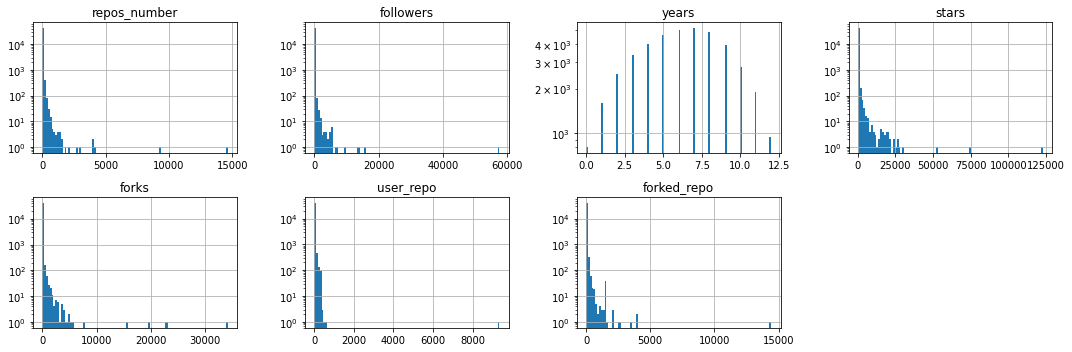

In [20]:
#we can see in all variables except for years and stars that the frequency of 0 es huge
figure = plt.figure(figsize=(15,5))

for n, c in enumerate(X.columns):
  ax = figure.add_subplot(2,4,n+1)
  ax.set_title(c)
  ax.set_yscale("log") #the log scale help us to have a better idea of our data when the distribution is not fair
  X[c].hist(ax=ax, bins=100)

figure.tight_layout() #this feature separate the graphs correctly
plt.show

Text(0.5, 1.0, 'Correlation matrix')

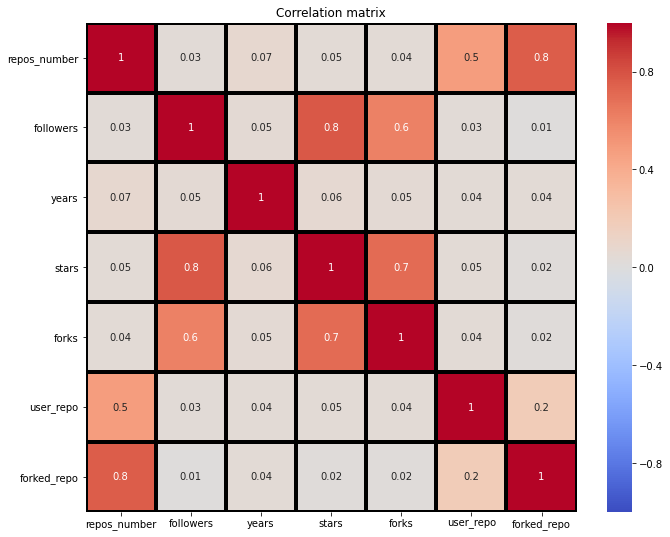

In [21]:
plt.figure(figsize=(11,9))

sns.heatmap(X.corr(), annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm' , linewidths=3, linecolor='black')

plt.title('Correlation matrix')

#### There is a big positive linear relation between followers, stars and forks. However none of the repo columns  neither yeas are related with the 3 previous vars. Therefore we will take these 3 vars as the main characteristics to determine the seniority of users

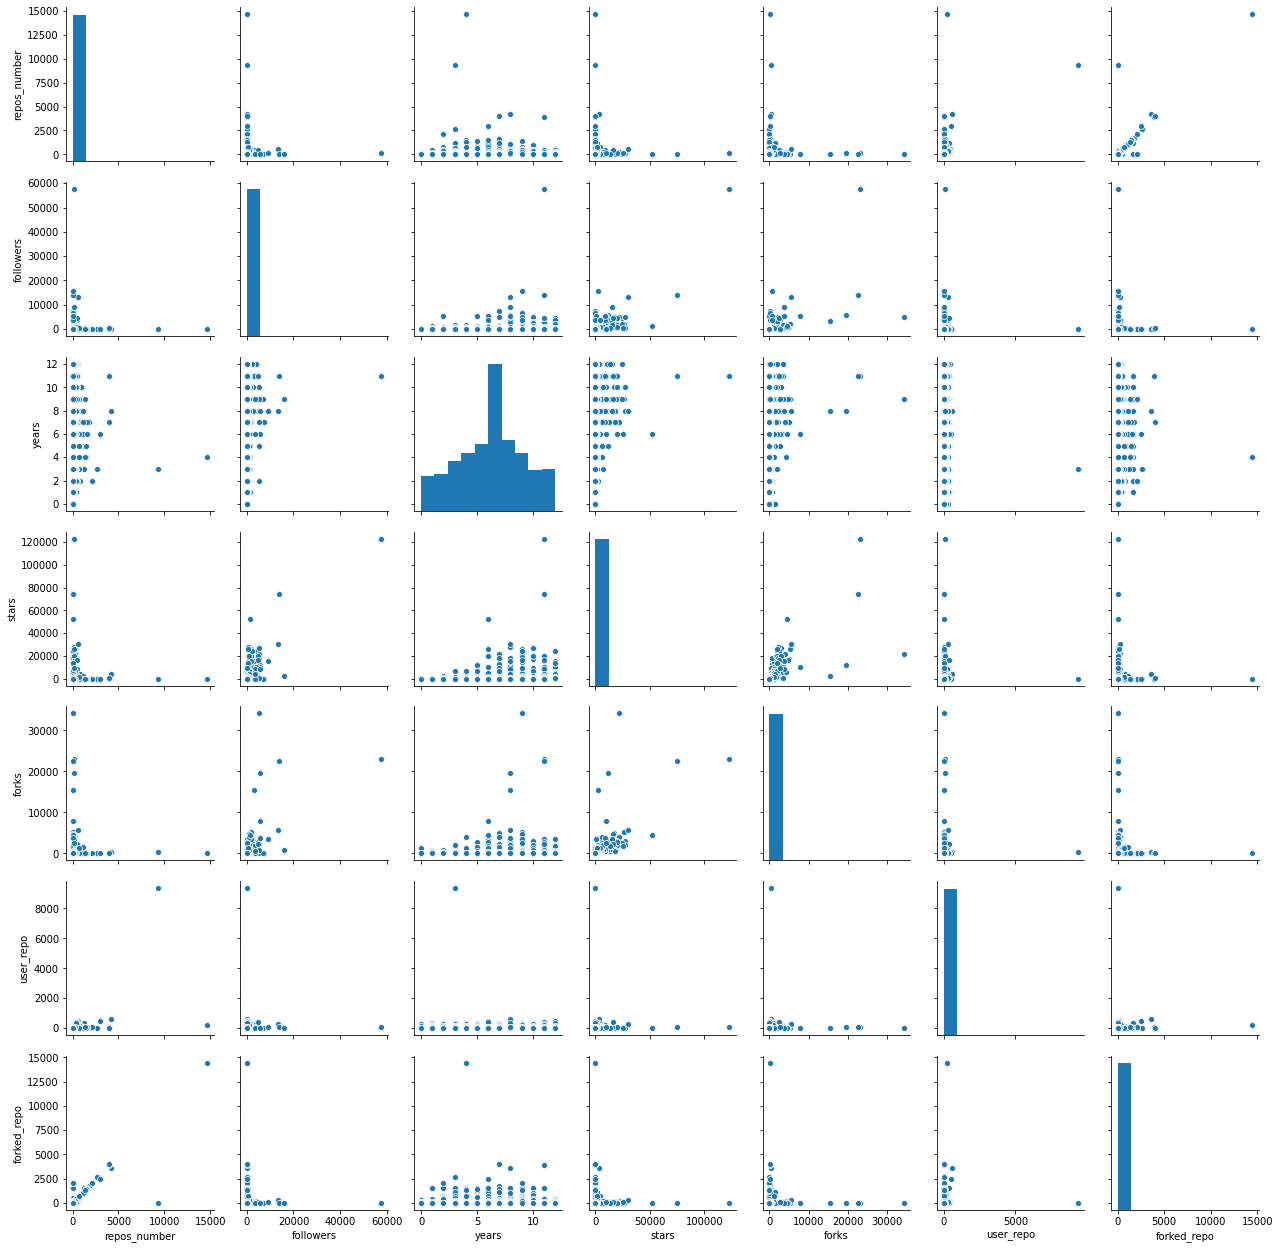

In [22]:
sns.pairplot(X)

#### Above we can see some columns with really huge outliers that could affect our cluster model. Therefore we will check these users deeply and decide whether to delete them or not

In [23]:
df[df.repos_number>5000]

,name,repos_number,followers,years,stars,forks,user_repo,forked_repo
3087,Andrew Carl,14637,27,4,48,39,204,14433
18002,Kanseki Repository 漢籍リポジトリ,9349,0,3,58,320,9349,0


In [24]:
df[df.followers>20000]

,name,repos_number,followers,years,stars,forks,user_repo,forked_repo
15084,Jake Wharton,102,57545,11,123102,23075,100,2


In [25]:
df[df.stars>45000]

,name,repos_number,followers,years,stars,forks,user_repo,forked_repo
15084,Jake Wharton,102,57545,11,123102,23075,100,2
30327,Salvatore Sanfilippo,63,13833,11,74629,22542,59,4
36831,Yoni Goldberg,18,1240,6,52132,4595,9,9


In [26]:
df[df.forks>10000]

,name,repos_number,followers,years,stars,forks,user_repo,forked_repo
2195,Allen Downey,105,5713,8,12031,19572,78,27
5137,Brian Caffo,57,3250,8,2481,15378,37,20
10624,Eugen,9,5119,9,21710,34154,9,0
15084,Jake Wharton,102,57545,11,123102,23075,100,2
30327,Salvatore Sanfilippo,63,13833,11,74629,22542,59,4


As we see, the previous outliers are far over the stantard sample, so we will delete them to have an accurate clustering model

In [27]:
df.drop(df[df.repos_number>5000].index, inplace=True)
df.drop(df[df.followers>20000].index, inplace=True)
df.drop(df[df.stars>45000].index, inplace=True)
df.drop(df[df.forks>10000].index, inplace=True)

#### To have a better clustering we proceeded to delete the outliers

(array([6., 0., 0., 1., 0., 0., 0., 0., 0., 1.]),
 array([ 0. ,  1.8,  3.6,  5.4,  7.2,  9. , 10.8, 12.6, 14.4, 16.2, 18. ]),
 <a list of 10 Patch objects>)

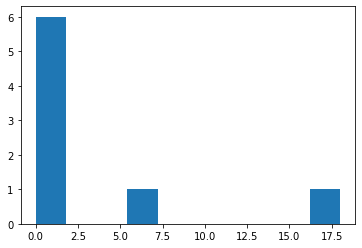

In [1]:
h = [0, 0, 0, 1, 1, 1, 6, 18]

import matplotlib.pyplot as plt
import numpy as np

plt.hist(h)

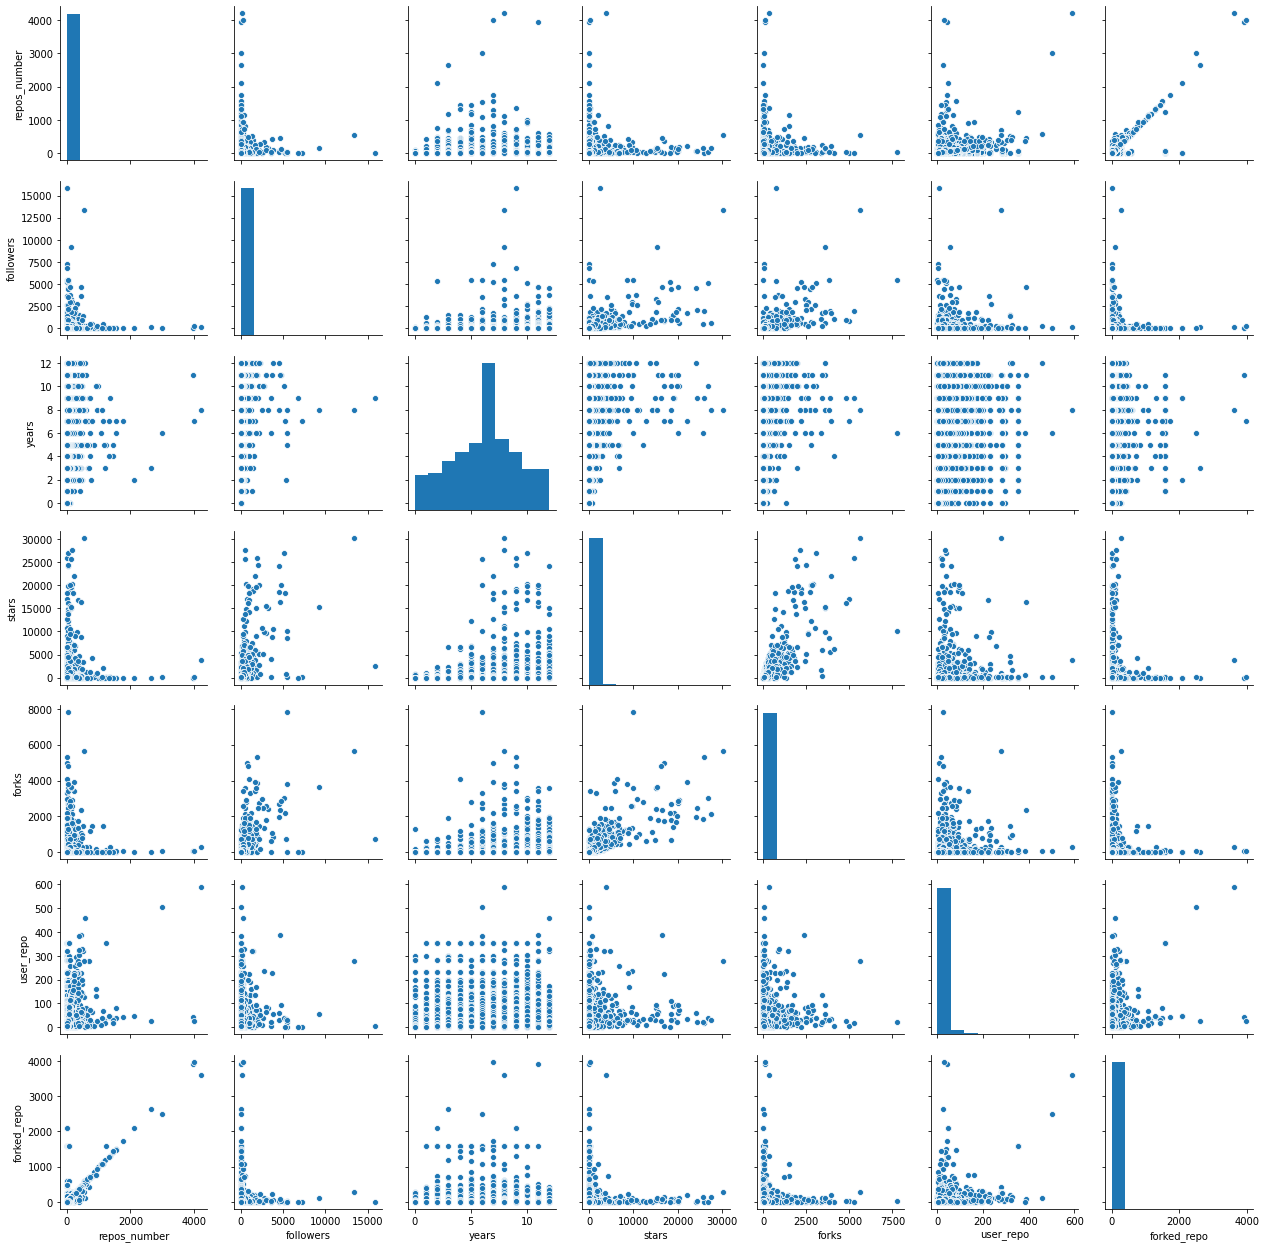

In [28]:
sns.pairplot(df)

#### Now we can see a better sample distribution than before, so we will go with this df

In [29]:
#we will exclude the id and the repos_number as we will use the user_repo and forked_repo for clustering
name = df.name
repos = df.repos_number
X = df.drop(columns={"name","repos_number"})

#### While our df shouldn't be scaled, as the scales of our vars have the same scales, except for years, we will test the standard and min max scalers for our model, as well as the normal df to chek which one give the best results

### Scale & Normalize

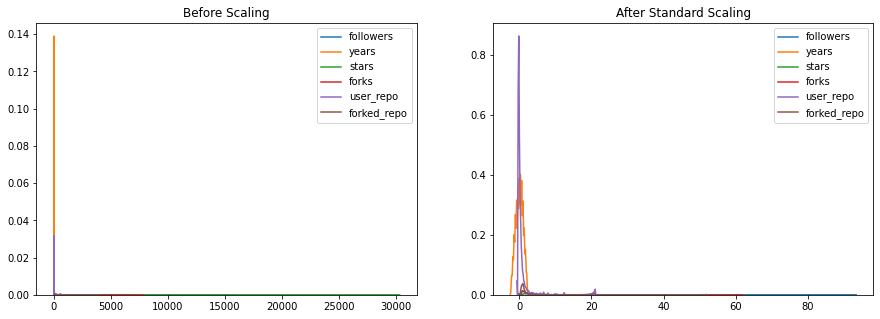

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

strans = scaler.fit_transform(X)

X_SS = pd.DataFrame(strans)
X_SS.columns = X.columns

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
ax1.set_title('Before Scaling')
for e in X.columns:
    sns.kdeplot(X[e], ax=ax1, legend=True)
ax2.set_title('After Standard Scaling')
for e in X_SS.columns:
    sns.kdeplot(X_SS[e], ax=ax2, legend=True)
plt.show()

### Hopkins Statistics:
The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

If the value is between {0.01, ...,0.3}, the data is regularly spaced.

If the value is around 0.5, it is random.

If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.


In [32]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [33]:
hopkins(X)

0.9985979578407203

### K Means

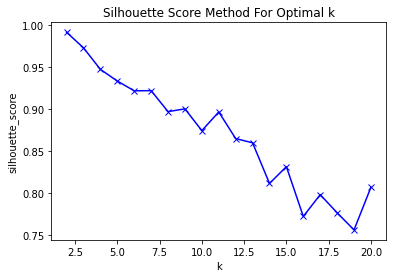

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


In [35]:
#we use the silhouette method to determine the ideal number of clusters. Although our clusters objective is 4-7
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil = []
kmax = 20
klusters = range(2, kmax+1)
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in klusters:
    km = KMeans(n_clusters = k).fit(X)
    labels = km.labels_
    sil.append(silhouette_score(X, labels, metric = 'euclidean'))
    
plt.plot(klusters, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Score Method For Optimal k')
plt.show()
%time

- Standard Scaler --> Optimal Clusters 3
- Min Max Scaler --> Optimal Clusters 20
- Dataframe --> Optimal Clusters 2

#### As the optimal clusters for standard scaler and the current df, are more similar to our goal (5 clusters), we will test both

In [36]:
model = KMeans(n_clusters=5)

labels = model.fit_predict(X)

In [37]:
df["label"] = labels

In [38]:
lab = df.label.value_counts()
lab

0    40757
3      463
2       75
1       24
4        8
Name: label, dtype: int64

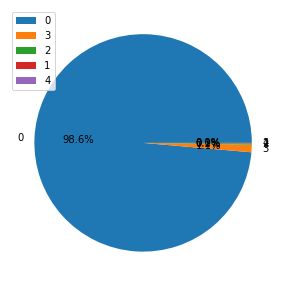

In [39]:
f, ax = plt.subplots(figsize=(15,5))
ax.pie(lab, labels=lab.keys(), autopct='%1.1f%%')
ax.legend(labels=lab.keys(), loc=2)

#### After testing the oirginal df and standard scaler, we saw a fairer distribution with the orifinal data, so we will go with it

In [40]:
df.head()

,name,repos_number,followers,years,stars,forks,user_repo,forked_repo,label
0,Aníbal Catheringer,2,1,6,0,0,2,0,0
1,Cohen,18,2,3,0,2,18,0,0
2,Enrico Antonello,43,14,7,7,2,28,15,0
3,Jakub Smadiš,16,1,3,0,0,3,13,0
4,Marián Černý,16,3,8,22,6,3,13,0


/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/diego/anaconda3/

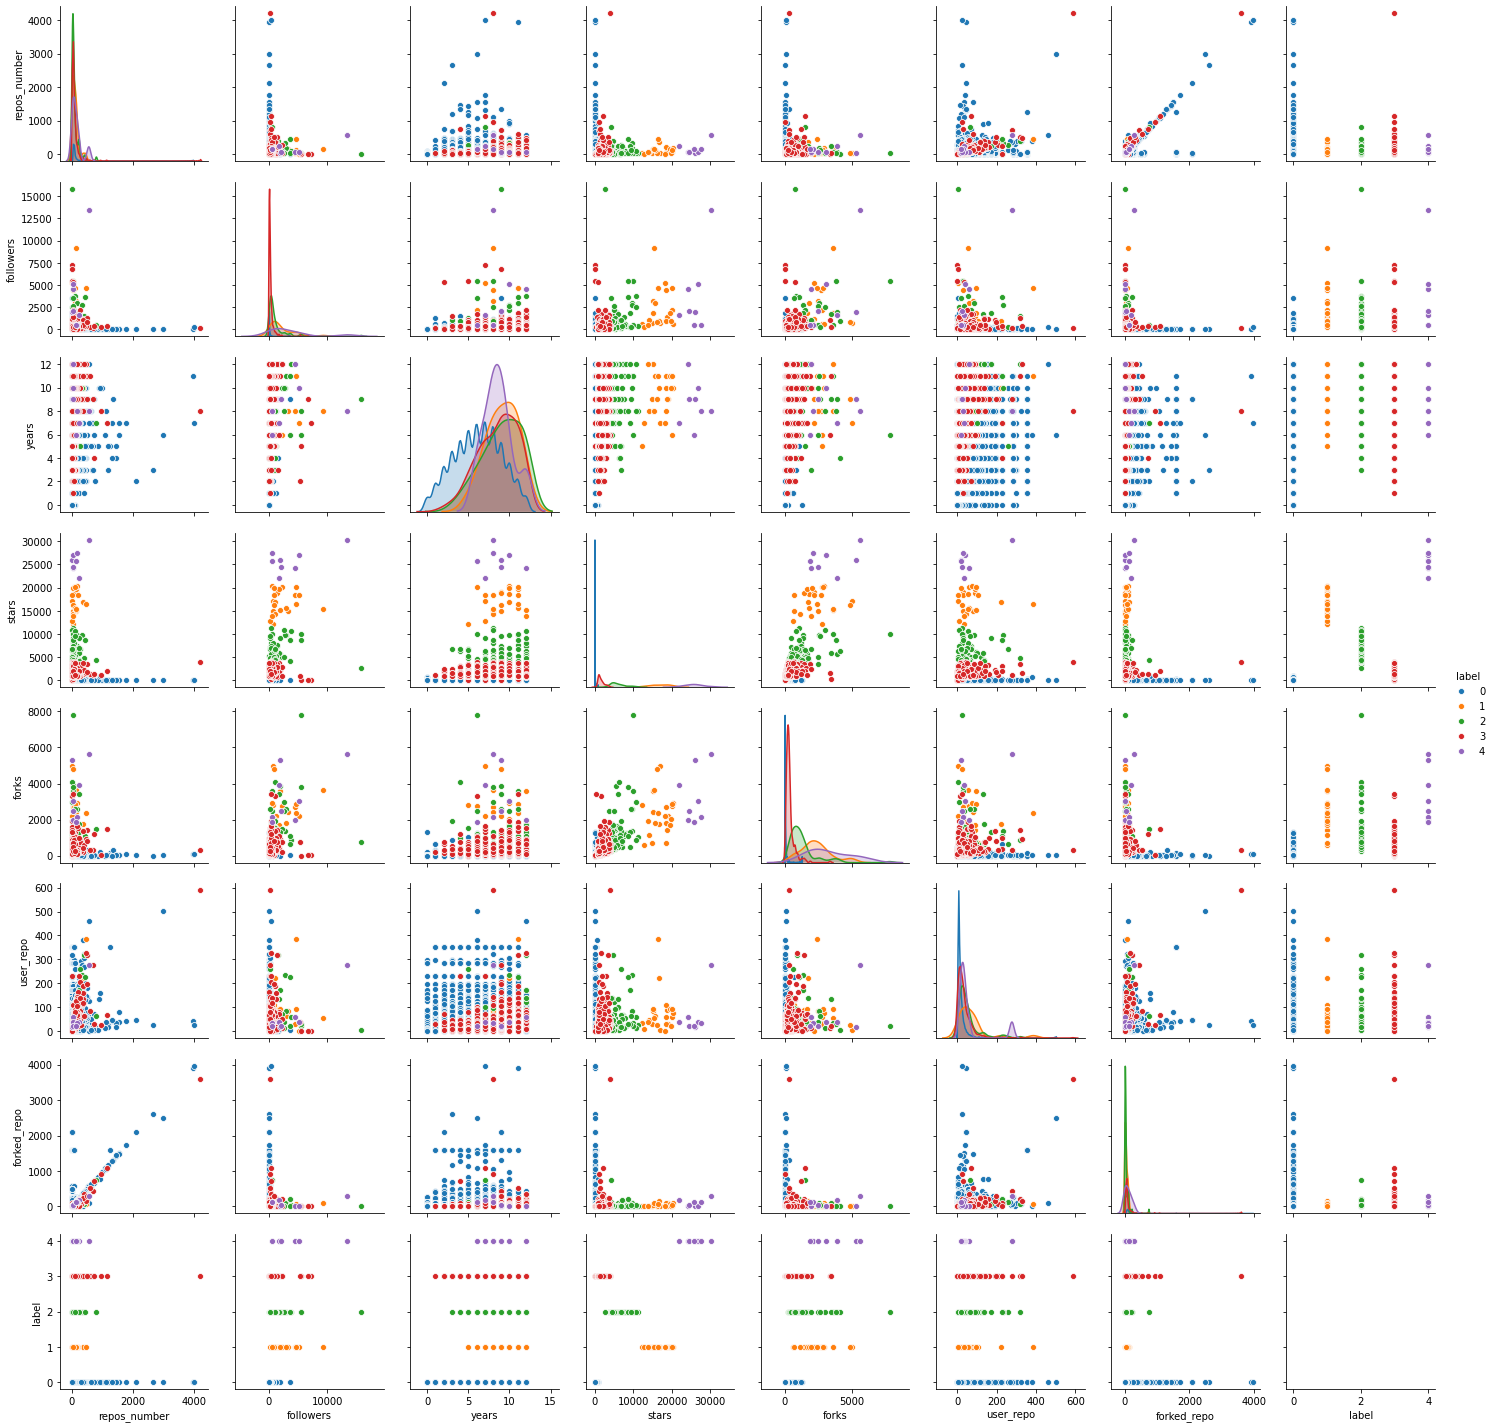

In [42]:
warnings.filterwarnings("ignore")

sns.pairplot(df, hue="label")

### This pairplot gives us the following conclusions:

- Label: we can see clearly that the model can identify differences between users by using the stars as a sign, while the other vars don't have a clear difference of labels
- Stars: as we know from before, stars is one of our main vars beacause it is highly correlated with forks and followers (being 3 out of 5 original columns)

### Therefore, as stars is the main characteristic to indentify the seniority of the users, we will usea followers as the main identifier in our next step (inside users characteristics we just have followes, repos number and years)

### 3d graphs with diff variables (would be interesting with 3 correlated ones --> stars, followers and forks